Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p tensorflow

Sebastian Raschka 

CPython 3.7.3
IPython 7.6.1

tensorflow 1.13.1


# Convolutional General Adversarial Networks

Implementation of General Adversarial Nets (GAN) where both the discriminator and generator have convolutional and deconvolutional layers, respectively. In this example, the GAN generator was trained to generate MNIST images.

Uses

- samples from a random normal distribution (range [-1, 1])
- dropout
- leaky relus
- batch normalization
- separate batches for "fake" and "real" images (where the labels are 1 = real images, 0 = fake images)
- MNIST images normalized to [-1, 1] range
- generator with tanh output


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import pickle as pkl

tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
### Abbreviatiuons
# dis_*: discriminator network
# gen_*: generator network

########################
### Helper functions
########################

def leaky_relu(x, alpha=0.0001):
    return tf.maximum(alpha * x, x)


########################
### DATASET
########################

mnist = input_data.read_data_sets('MNIST_data')


#########################
### SETTINGS
#########################

# Hyperparameters
learning_rate = 0.001
training_epochs = 50
batch_size = 64
dropout_rate = 0.5

# Architecture
dis_input_size = 784
gen_input_size = 100

# Other settings
print_interval = 200

#########################
### GRAPH DEFINITION
#########################

g = tf.Graph()
with g.as_default():
    
    # Placeholders for settings
    dropout = tf.placeholder(tf.float32, shape=None, name='dropout')
    is_training = tf.placeholder(tf.bool, shape=None, name='is_training')
    
    # Input data
    dis_x = tf.placeholder(tf.float32, shape=[None, dis_input_size],
                           name='discriminator_inputs')     
    gen_x = tf.placeholder(tf.float32, [None, gen_input_size],
                           name='generator_inputs')


    ##################
    # Generator Model
    ##################

    with tf.variable_scope('generator'):
        
        # 100 => 784 => 7x7x64
        gen_fc = tf.layers.dense(inputs=gen_x, units=3136,
                                 bias_initializer=None, # no bias required when using batch_norm
                                 activation=None)
        gen_fc = tf.layers.batch_normalization(gen_fc, training=is_training)
        gen_fc = leaky_relu(gen_fc)
        gen_fc = tf.reshape(gen_fc, (-1, 7, 7, 64))
        
        # 7x7x64 => 14x14x32
        deconv1 = tf.layers.conv2d_transpose(gen_fc, filters=32, 
                                             kernel_size=(3, 3), strides=(2, 2), 
                                             padding='same',
                                             bias_initializer=None,
                                             activation=None)
        deconv1 = tf.layers.batch_normalization(deconv1, training=is_training)
        deconv1 = leaky_relu(deconv1)     
        deconv1 = tf.layers.dropout(deconv1, rate=dropout_rate)
        
        # 14x14x32 => 28x28x16
        deconv2 = tf.layers.conv2d_transpose(deconv1, filters=16, 
                                             kernel_size=(3, 3), strides=(2, 2), 
                                             padding='same',
                                             bias_initializer=None,
                                             activation=None)
        deconv2 = tf.layers.batch_normalization(deconv2, training=is_training)
        deconv2 = leaky_relu(deconv2)     
        deconv2 = tf.layers.dropout(deconv2, rate=dropout_rate)
        
        # 28x28x16 => 28x28x8
        deconv3 = tf.layers.conv2d_transpose(deconv2, filters=8, 
                                             kernel_size=(3, 3), strides=(1, 1), 
                                             padding='same',
                                             bias_initializer=None,
                                             activation=None)
        deconv3 = tf.layers.batch_normalization(deconv3, training=is_training)
        deconv3 = leaky_relu(deconv3)     
        deconv3 = tf.layers.dropout(deconv3, rate=dropout_rate)
        
        # 28x28x8 => 28x28x1
        gen_logits = tf.layers.conv2d_transpose(deconv3, filters=1, 
                                                kernel_size=(3, 3), strides=(1, 1), 
                                                padding='same',
                                                bias_initializer=None,
                                                activation=None)
        gen_out = tf.tanh(gen_logits, 'generator_outputs')


    ######################
    # Discriminator Model
    ######################
    
    def build_discriminator_graph(input_x, reuse=None):

        with tf.variable_scope('discriminator', reuse=reuse):
            
            # 28x28x1 => 14x14x8
            conv_input = tf.reshape(input_x, (-1, 28, 28, 1))
            conv1 = tf.layers.conv2d(conv_input, filters=8, kernel_size=(3, 3),
                                     strides=(2, 2), padding='same',
                                     bias_initializer=None,
                                     activation=None)
            conv1 = tf.layers.batch_normalization(conv1, training=is_training)
            conv1 = leaky_relu(conv1)
            conv1 = tf.layers.dropout(conv1, rate=dropout_rate)
            
            # 14x14x8 => 7x7x32
            conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size=(3, 3),
                                     strides=(2, 2), padding='same',
                                     bias_initializer=None,
                                     activation=None)
            conv2 = tf.layers.batch_normalization(conv2, training=is_training)
            conv2 = leaky_relu(conv2)
            conv2 = tf.layers.dropout(conv2, rate=dropout_rate)

            # fully connected layer
            fc_input = tf.reshape(conv2, (-1, 7*7*32))
            logits = tf.layers.dense(inputs=fc_input, units=1, activation=None)
            out = tf.sigmoid(logits)
            
        return logits, out    

    # Create a discriminator for real data and a discriminator for fake data
    dis_real_logits, dis_real_out = build_discriminator_graph(dis_x, reuse=False)
    dis_fake_logits, dis_fake_out = build_discriminator_graph(gen_out, reuse=True)


    #####################################
    # Generator and Discriminator Losses
    #####################################
    
    # Two discriminator cost components: loss on real data + loss on fake data
    # Real data has class label 1, fake data has class label 0
    dis_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_real_logits, 
                                                            labels=tf.ones_like(dis_real_logits))
    dis_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logits, 
                                                            labels=tf.zeros_like(dis_fake_logits))
    dis_cost = tf.add(tf.reduce_mean(dis_fake_loss), 
                      tf.reduce_mean(dis_real_loss), 
                      name='discriminator_cost')
 
    # Generator cost: difference between dis. prediction and label "1" for real images
    gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logits,
                                                       labels=tf.ones_like(dis_fake_logits))
    gen_cost = tf.reduce_mean(gen_loss, name='generator_cost')
    
    
    #########################################
    # Generator and Discriminator Optimizers
    #########################################
      
    dis_optimizer = tf.train.AdamOptimizer(learning_rate)
    dis_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator')
    dis_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    
    with tf.control_dependencies(dis_update_ops): # required to upd. batch_norm params
        dis_train = dis_optimizer.minimize(dis_cost, var_list=dis_train_vars,
                                           name='train_discriminator')
    
    gen_optimizer = tf.train.AdamOptimizer(learning_rate)
    gen_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator')
    gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    
    with tf.control_dependencies(gen_update_ops): # required to upd. batch_norm params
        gen_train = gen_optimizer.minimize(gen_cost, var_list=gen_train_vars,
                                           name='train_generator')
    
    # Saver to save session for reuse
    saver = tf.train.Saver()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:


In [4]:
##########################
### TRAINING & EVALUATION
##########################

with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    avg_costs = {'discriminator': [], 'generator': []}

    for epoch in range(training_epochs):
        dis_avg_cost, gen_avg_cost = 0., 0.
        total_batch = mnist.train.num_examples // batch_size

        for i in range(total_batch):
            
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            batch_x = batch_x*2 - 1 # normalize
            batch_randsample = np.random.uniform(-1, 1, size=(batch_size, gen_input_size))
            
            # Train
            
            _, dc = sess.run(['train_discriminator', 'discriminator_cost:0'],
                             feed_dict={'discriminator_inputs:0': batch_x, 
                                        'generator_inputs:0': batch_randsample,
                                        'dropout:0': dropout_rate,
                                        'is_training:0': True})
            
            _, gc = sess.run(['train_generator', 'generator_cost:0'],
                             feed_dict={'generator_inputs:0': batch_randsample,
                                        'dropout:0': dropout_rate,
                                        'is_training:0': True})
            
            dis_avg_cost += dc
            gen_avg_cost += gc

            if not i % print_interval:
                print("Minibatch: %04d | Dis/Gen Cost:    %.3f/%.3f" % (i + 1, dc, gc))
                

        print("Epoch:     %04d | Dis/Gen AvgCost: %.3f/%.3f" % 
              (epoch + 1, dis_avg_cost / total_batch, gen_avg_cost / total_batch))
        
        avg_costs['discriminator'].append(dis_avg_cost / total_batch)
        avg_costs['generator'].append(gen_avg_cost / total_batch)
    
    
    saver.save(sess, save_path='./gan-conv.ckpt')

Minibatch: 0001 | Dis/Gen Cost:    1.630/0.866
Minibatch: 0201 | Dis/Gen Cost:    0.850/1.879
Minibatch: 0401 | Dis/Gen Cost:    0.606/2.467
Minibatch: 0601 | Dis/Gen Cost:    0.695/1.661
Minibatch: 0801 | Dis/Gen Cost:    1.149/1.297
Epoch:     0001 | Dis/Gen AvgCost: 0.820/1.887
Minibatch: 0001 | Dis/Gen Cost:    0.707/1.486
Minibatch: 0201 | Dis/Gen Cost:    0.924/1.438
Minibatch: 0401 | Dis/Gen Cost:    0.751/1.508
Minibatch: 0601 | Dis/Gen Cost:    0.899/1.611
Minibatch: 0801 | Dis/Gen Cost:    0.914/1.535
Epoch:     0002 | Dis/Gen AvgCost: 0.954/1.510
Minibatch: 0001 | Dis/Gen Cost:    0.498/1.955
Minibatch: 0201 | Dis/Gen Cost:    0.757/1.670
Minibatch: 0401 | Dis/Gen Cost:    1.100/1.204
Minibatch: 0601 | Dis/Gen Cost:    0.656/2.054
Minibatch: 0801 | Dis/Gen Cost:    1.036/1.174
Epoch:     0003 | Dis/Gen AvgCost: 0.784/1.720
Minibatch: 0001 | Dis/Gen Cost:    1.576/0.992
Minibatch: 0201 | Dis/Gen Cost:    0.663/2.002
Minibatch: 0401 | Dis/Gen Cost:    0.869/1.773
Minibatch: 06

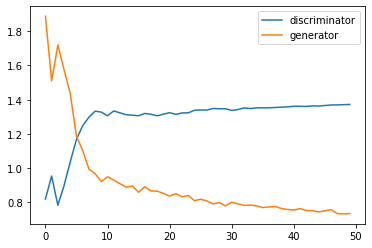

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(len(avg_costs['discriminator'])), 
         avg_costs['discriminator'], label='discriminator')
plt.plot(range(len(avg_costs['generator'])),
         avg_costs['generator'], label='generator')
plt.legend()
plt.show()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./gan-conv.ckpt


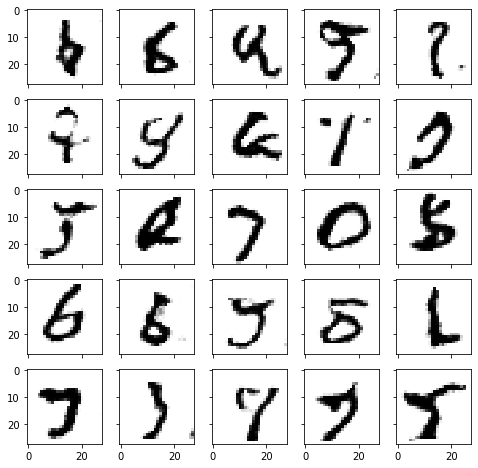

In [6]:
####################################
### RELOAD & GENERATE SAMPLE IMAGES
####################################


n_examples = 25

with tf.Session(graph=g) as sess:
    saver.restore(sess, save_path='./gan-conv.ckpt')

    batch_randsample = np.random.uniform(-1, 1, size=(n_examples, gen_input_size))
    new_examples = sess.run('generator/generator_outputs:0',
                            feed_dict={'generator_inputs:0': batch_randsample,
                                       'dropout:0': 0.0,
                                       'is_training:0': False})

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8),
                         sharey=True, sharex=True)

for image, ax in zip(new_examples, axes.flatten()):
    ax.imshow(image.reshape((dis_input_size // 28, dis_input_size // 28)), cmap='binary')

plt.show()